In [1]:
import torch
import torch
import torch.utils.data
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import TQDMProgressBar

from livecell_tracker.model_zoo.segmentation.sc_correction import CorrectSegNet
import numpy as np
torch.manual_seed(237)


In [2]:
torch.cuda.is_available(), torch.cuda.current_device(), torch.cuda.device_count()

(True, 0, 8)

In [3]:
ckpt = r"./correct_segmentation_network/epoch=2570-test_out_matched_num_gt_iou_0.5_percent_real_underseg_cases=0.8548.ckpt"

model = CorrectSegNet.load_from_checkpoint(ckpt)
# model.load_state_dict(torch.load(ckpt)["state_dict"])
model.cuda();
model.eval();

Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file correct_segmentation_network/epoch=2570-test_out_matched_num_gt_iou_0.5_percent_real_underseg_cases=0.8548.ckpt`
/net/capricorn/home/xing/yak53/.conda/envs/livecell/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/net/capricorn/home/xing/yak53/.conda/envs/livecell/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most

>>> Using MSE loss
>>> Based on loss type, training output threshold:  1


In [8]:
def viz_sample_v3(sample: dict, model, raw_seg=None, scale=None, out_threshold=0.6, save_path=None, close_on_save=True):
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    def add_colorbar(im, ax, fig):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.05)
        fig.colorbar(im, cax=cax, orientation="vertical")

    out_mask = model(sample["input"].unsqueeze(0).cuda())
    original_input_mask = sample["input"].cpu().numpy().squeeze()[2]
    # original_input_mask = sample["input"].numpy().squeeze()[2]
    original_input_mask = original_input_mask.astype(bool)

    # gt_mask = sample["gt_mask"].numpy().squeeze()
    out_mask = out_mask[0].cpu().detach().numpy()
    fig, axes = plt.subplots(1, 12, figsize=(12 * 7, 6))

    ax_idx = 0
    ax = axes[ax_idx]
    ax.imshow(sample["input"][0].cpu().numpy())
    ax.set_title("input: dim0")

    ax_idx += 1
    ax = axes[ax_idx]
    ax.imshow(sample["input"][1].cpu().numpy())
    ax.set_title("input: dim1")

    ax_idx += 1
    ax = axes[ax_idx]
    ax.imshow(sample["input"][2].cpu().numpy())
    ax.set_title("input:dim2")

    ax_idx += 1
    ax = axes[ax_idx]
    im2 = ax.imshow(out_mask[0, :])
    ax.set_title("out0seg")
    add_colorbar(im2, ax, fig)

    # ax_idx += 1
    # ax = axes[ax_idx]
    # ax.imshow(gt_mask[0, :])
    # ax.set_title("gt0 seg")

    ax_idx += 1
    ax = axes[ax_idx]
    im4 = ax.imshow(out_mask[1, :])
    ax.set_title("out1seg")
    add_colorbar(im4, ax, fig)

    # ax_idx += 1
    # ax = axes[ax_idx]
    # im5 = ax.imshow(gt_mask[1, :])
    # add_colorbar(im5, ax, fig)
    # ax.set_title("gt1 seg")

    ax_idx += 1
    ax = axes[ax_idx]
    im6 = ax.imshow(out_mask[2, :])
    add_colorbar(im6, ax, fig)
    ax.set_title("out2 seg")

    # ax_idx += 1
    # ax = axes[ax_idx]
    # im7 = ax.imshow(gt_mask[2, :])
    # add_colorbar(im7, ax, fig)
    # ax.set_title("gt2 seg")

    combined_over_under_seg = np.zeros([3] + list(out_mask.shape[1:]))
    combined_over_under_seg[0, out_mask[1, :] > out_threshold] = 1
    combined_over_under_seg[1, out_mask[2, :] > out_threshold] = 1

    ax_idx += 1
    ax = axes[ax_idx]
    im = ax.imshow(np.moveaxis(combined_over_under_seg, 0, 2))
    ax.set_title("out(1,2), over/under seg combined")

    # import matplotlib.patches as mpatches
    # values = [-1, 0, 1]
    # colors = [im.cmap(im.norm(value)) for value in values]
    # patches = [mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values))]
    # ax.legend(handles=patches, loc=2, borderaxespad=0. )
    ax_idx += 1
    ax = axes[ax_idx]
    ax.imshow(out_mask[0] > out_threshold)
    ax.set_title(f"out0 >{out_threshold} threshold")

    out_mask_predicted = out_mask[0] > out_threshold
    # ignore pixels outside an area, only works for undersegmentation
    # out_mask_predicted[original_input_mask < 0.5] = 0
    out_mask_predicted = out_mask_predicted.astype(bool)

    ax_idx += 1
    ax = axes[ax_idx]
    ax.imshow(out_mask_predicted)
    ax.set_title(f"cleaned out mask prediction")

    if save_path is not None:
        plt.savefig(save_path)
    if save_path and close_on_save:
        plt.close()


40 tif img file paths loaded: 
40 png img file paths loaded: 


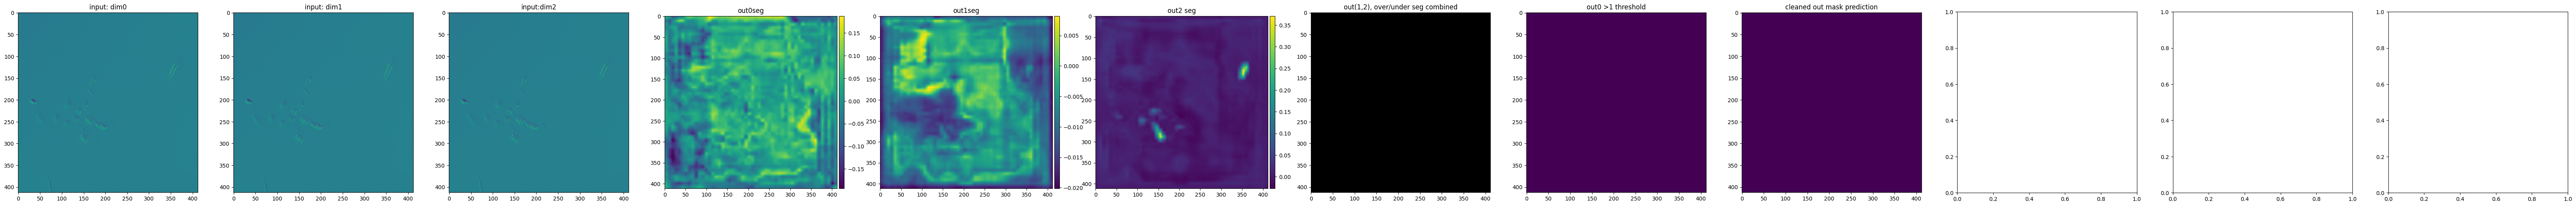

In [10]:
#  MY OWN MODIFICATIONS

from livecell_tracker.core.datasets import LiveCellImageDataset, SingleImageDataset
from livecell_tracker.preprocess.utils import normalize_img_to_uint8

from PIL import Image
import cv2
import tifffile
from skimage.transform import resize as resize2
from pathlib import Path
import matplotlib.pyplot as plt


dataset_dir_path = Path(
    "../datasets/test_data_STAV-A549/DIC_data"
)

mask_dataset_path = Path("../datasets/test_data_STAV-A549/mask_data")

dic_dataset = LiveCellImageDataset(dataset_dir_path, ext="tif")

mask_dataset = LiveCellImageDataset(mask_dataset_path, ext="png")

mask_img = Image.open(mask_dataset.time2url[0]).resize((412, 412))

# Open the image using tifffile
img = resize2(tifffile.imread(dic_dataset.time2url[0]), (412, 412))
img = normalize_img_to_uint8(img)
stacked_img = np.stack((img,)*3, axis=-1).T

mask_img = np.array(mask_img.convert('1'))
mask_img = np.where(mask_img == 0, -1, 1)
# Reshape mask_img to have the same shape as stacked_img
mask_img = np.tile(mask_img[..., np.newaxis], (1, 1, 3)).T

merged_img = mask_img*stacked_img


# from livecell_tracker.model_zoo.segmentation.eval_csn import viz_sample_v3

input_tensor = torch.from_numpy(merged_img)
input_tensor = input_tensor.to(torch.float32).cuda()
    
sample = {"input": input_tensor}
viz_sample_v3(sample, model, out_threshold=1)


# print(input_tensor)  # should print (3, height, width)
# print(merged_img)
# print(merged_img.dtype)  # should print torch.float32




(array([5.09007e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 2.25000e+02]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

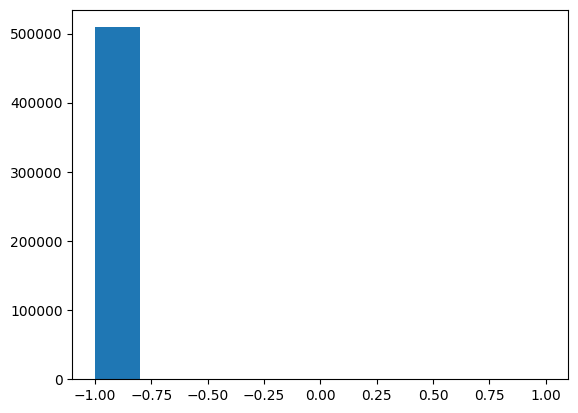

In [13]:
plt.hist(mask_img.flatten())

(array([5.0000e+00, 8.0000e+00, 2.4000e+01, 7.1800e+02, 1.6873e+05,
        1.7100e+02, 1.3000e+01, 0.0000e+00, 3.8000e+01, 3.7000e+01]),
 array([-255. , -216.8, -178.6, -140.4, -102.2,  -64. ,  -25.8,   12.4,
          50.6,   88.8,  127. ]),
 <BarContainer object of 10 artists>)

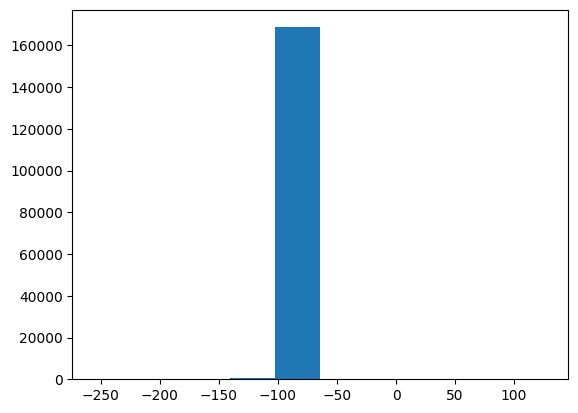

In [11]:
plt.hist(merged_img[0].flatten())

In [6]:
from pathlib import Path
import pandas as pd
# train_dir = Path("./notebook_results/a549_ccp_vim/train_data_v4/")
# test_dir = Path("./notebook_results/a549_ccp_vim/test_data_v4/")
train_dir = Path("./notebook_results/a549_ccp_vim/train_data_v5/")
test_dir = Path("./notebook_results/a549_ccp_vim/test_data_v5/")

# train_csv = train_dir / "train_data.csv"
# train_df = pd.read_csv(train_csv)
# test_df = pd.read_csv(test_dir / "train_data.csv")
# train_df[:2]

In [4]:
# ckpt = "/home/ke/LiveCellTracker-dev/notebooks/lightning_logs/version_68/checkpoints/epoch=197-step=44352.ckpt"
# ckpt = "/home/ke/LiveCellTracker-dev/notebooks/lightning_logs/version_67/checkpoints/epoch=440-step=98784.ckpt"
# ckpt = "/home/ke/LiveCellTracker-dev/notebooks/lightning_logs/version_67/epoch=499-step=112000.ckpt"

# # model 70 v0
# ckpt = r"/home/ke/LiveCellTracker-dev/notebooks/lightning_logs/version_70/checkpoints/epoch=999-step=224000.ckpt"
# # model 70 v1
# ckpt = r"/home/ke/LiveCellTracker-dev/notebooks/lightning_logs/version_70/checkpoints/epoch=999-step=224000-v1.ckpt"
# ckpt = r"/home/ke/LiveCellTracker-dev/notebooks/lightning_logs/version_71/checkpoints/epoch=999-step=224000.ckpt"
# # model 73
# ckpt = r"/home/ken67/LiveCellTracker-dev/notebooks/lightning_logs/version_73/epoch=421-step=94528.ckpt"

# # model 76
# ckpt = r"/home/ken67/LiveCellTracker-dev/notebooks/lightning_logs/version_85/checkpoints/epoch=999-step=224000.ckpt"
ckpt = r"./correct_segmentation_network/epoch=2570-test_out_matched_num_gt_iou_0.5_percent_real_underseg_cases=0.8548.ckpt"

model = CorrectSegNet.load_from_checkpoint(ckpt)
# model.load_state_dict(torch.load(ckpt)["state_dict"])
model.cuda();
model.eval();

Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file correct_segmentation_network/epoch=2570-test_out_matched_num_gt_iou_0.5_percent_real_underseg_cases=0.8548.ckpt`
/net/capricorn/home/xing/yak53/.conda/envs/livecell/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/net/capricorn/home/xing/yak53/.conda/envs/livecell/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most

>>> Using MSE loss
>>> Based on loss type, training output threshold:  1


In [6]:
from livecell_tracker.model_zoo.segmentation.eval_csn import assemble_dataset, assemble_train_test_dataset

# split_seed = 237
# dataset = assemble_dataset(train_df, apply_gt_seg_edt = model.apply_gt_seg_edt, exclude_raw_input_bg=model.exclude_raw_input_bg, input_type=model.input_type)
# train_sample_num = int(len(dataset) * 0.8)
# val_sample_num = len(dataset) - train_sample_num
# split_generator = torch.Generator().manual_seed(split_seed)
# train_dataset, val_dataset = torch.utils.data.random_split(
#     dataset, [train_sample_num, val_sample_num], generator=split_generator
# )

# test_dataset = assemble_dataset(test_df, apply_gt_seg_edt = model.apply_gt_seg_edt, exclude_raw_input_bg=model.exclude_raw_input_bg, input_type=model.input_type)
train_dataset, val_dataset, test_dataset, dataset = assemble_train_test_dataset(train_df, test_df, model)

In [7]:
# OUT_THRESHOLD = 1
OUT_THRESHOLD = 0.5

## Evaluate

Three cases:
correct segmentation case
oversegmentatin
undersegmentation
Can one mdoel correct three cases?
E.g. correct single cell mask ---model---> correct mask as well

In [6]:
import matplotlib.pyplot as plt
from livecell_tracker.model_zoo.segmentation.sc_correction_dataset import CorrectSegNetDataset
from livecell_tracker.model_zoo.segmentation.eval_csn import evaluate_sample_v3_underseg, match_label_mask_by_iou
import numpy as np

## Generate metrics 

Visualize one sample

In [9]:
import skimage.measure
import random
out_threshold = OUT_THRESHOLD
# idx = 0
# randomly select an index
idx = random.randint(0, len(train_dataset) - 1)
sample = train_dataset[idx]
origin_idx = train_dataset.indices[idx]
gt_label_mask = dataset.get_gt_label_mask(origin_idx)
original_input_mask = sample["seg_mask"].numpy().squeeze()
original_input_mask = original_input_mask.astype(bool)
print("original_input_mask.shape", original_input_mask.shape)

out_mask = model(sample["input"].unsqueeze(0).cuda())
out_mask = out_mask[0].cpu().detach().numpy()
print("out_mask shape", out_mask.shape)
out_mask_predicted = out_mask[0] > out_threshold
# out_mask_predicted[original_input_mask < 0.5] = 0
out_mask_predicted = out_mask_predicted.astype(bool)

out_label_mask = skimage.measure.label(out_mask_predicted)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
ax = axes[0]
ax.set_title("input")
ax.imshow(sample["input"][0])
ax = axes[1]
ax.set_title("origin_seg_mask")
ax.imshow(sample["seg_mask"])
ax = axes[2]
ax.set_title("out_mask_predicted")
ax.imshow(out_mask_predicted)
ax = axes[3]
ax.set_title("out_label_mask")
ax.imshow(out_label_mask)
ax = axes[4]
ax.set_title("gt_label_mask")
ax.imshow(gt_label_mask)

match_label_mask_by_iou(out_label_mask, gt_label_mask, match_threshold=0.8)


NameError: name 'train_dataset' is not defined

### On Testing Dataset

In [10]:
import tqdm
test_metrics = {}
for i, sample in tqdm.tqdm(enumerate(test_dataset)):
    # print(sample.keys())
    gt_label_mask = test_dataset.get_gt_label_mask(i)
    single_sample_metrics = evaluate_sample_v3_underseg(sample, model, out_threshold=OUT_THRESHOLD, gt_label_mask=gt_label_mask)
    

    for metric, value in single_sample_metrics.items():
        if metric not in test_metrics:
            test_metrics[metric] = []
        test_metrics[metric].append(value)

for key in test_metrics:
    test_metrics[key] = np.array(test_metrics[key])

NameError: name 'test_dataset' is not defined

In [11]:
import seaborn as sns
data = {
    "csn" : test_metrics["out_mask_accuracy"],
    "original" : test_metrics["original_mask_accuracy"],
}
print("csn mean:", np.mean(data["csn"]))
print("csn std:", np.std(data["csn"]))
print("original mean:", np.mean(data["original"]))
print("original std:", np.std(data["original"]))
bins = 20
plt.hist(data["csn"], bins=bins, alpha=0.5, label="csn", edgecolor='black', linewidth=1)
plt.hist(data["original"], bins=bins, alpha=0.5, label="original", edgecolor='black', linewidth=1)
plt.title("Pixel Accuracy Per Single Cell Image")
plt.legend()

KeyError: 'out_mask_accuracy'

In [12]:
data = {
    "csn" : test_metrics["out_mask_iou"],
    "original" : test_metrics["original_mask_iou"],
}
print("csn mean:", np.mean(data["csn"]))
print("csn std:", np.std(data["csn"]))
print("original mean:", np.mean(data["original"]))
print("original std:", np.std(data["original"]))
bins = 20
plt.hist(data["csn"], bins=bins, alpha=0.5, label="csn", edgecolor='black', linewidth=1)
plt.hist(data["original"], bins=bins, alpha=0.5, label="original", edgecolor='black', linewidth=1)
plt.title("IOU comparison Per Single Cell Image")
plt.legend()

KeyError: 'out_mask_iou'

Check the real underseg cases

In [13]:
real_underseg_test_df = test_df[test_df["subdir"] == "real_underseg_cases"]
print(len(real_underseg_test_df))
real_underseg_test_df[:2]

NameError: name 'test_df' is not defined

In [14]:
real_underseg_test_dataset = assemble_dataset(
        real_underseg_test_df,
        apply_gt_seg_edt=model.apply_gt_seg_edt,
        exclude_raw_input_bg=model.exclude_raw_input_bg,
        input_type=model.input_type,
)

NameError: name 'real_underseg_test_df' is not defined

In [15]:
underseg_test_metrics = {}
for i, sample in enumerate(tqdm.tqdm(real_underseg_test_dataset)):
    # print(sample.keys())
    gt_label_mask = real_underseg_test_dataset.get_gt_label_mask(i)
    single_sample_metrics = evaluate_sample_v3_underseg(sample, model, out_threshold=OUT_THRESHOLD, gt_label_mask=gt_label_mask)
    for metric, value in single_sample_metrics.items():
        if metric not in underseg_test_metrics:
            underseg_test_metrics[metric] = []
        underseg_test_metrics[metric].append(value)

for key in underseg_test_metrics:
    underseg_test_metrics[key] = np.array(underseg_test_metrics[key])

NameError: name 'real_underseg_test_dataset' is not defined

In [16]:
data = {
    "csn" : underseg_test_metrics["out_mask_accuracy"],
    "original" : underseg_test_metrics["original_mask_accuracy"],
}
print("csn mean:", np.mean(data["csn"]))
print("csn std:", np.std(data["csn"]))
print("original mean:", np.mean(data["original"]))
print("original std:", np.std(data["original"]))

KeyError: 'out_mask_accuracy'

In [17]:
import warnings
warnings.filterwarnings("ignore")
from livecell_tracker.model_zoo.segmentation.eval_csn import viz_sample_v3
for i, sample in enumerate(real_underseg_test_dataset):
    # print(sample.keys())
    viz_sample_v3(sample, model, out_threshold=OUT_THRESHOLD)
    if i > 10:
        break
warnings.filterwarnings("default")

NameError: name 'real_underseg_test_dataset' is not defined

### Evaluate on training dataset

In [18]:
import tqdm
train_metrics = {}
for i, sample in enumerate(tqdm.tqdm((train_dataset))):
    # print(sample.keys())
    origin_idx = train_dataset.indices[i]
    gt_label_mask = dataset.get_gt_label_mask(origin_idx)
    single_sample_metrics = evaluate_sample_v3_underseg(sample, model, out_threshold=OUT_THRESHOLD, gt_label_mask=gt_label_mask)
    for metric, value in single_sample_metrics.items():
        if metric not in train_metrics:
            train_metrics[metric] = []
        train_metrics[metric].append(value)

for key in train_metrics:
    train_metrics[key] = np.array(train_metrics[key])

NameError: name 'train_dataset' is not defined

In [19]:
import seaborn as sns
data = {
    "csn" : train_metrics["out_mask_accuracy"],
    "original" : train_metrics["original_mask_accuracy"],
}
print("csn mean:", np.mean(data["csn"]))
print("csn std:", np.std(data["csn"]))
print("original mean:", np.mean(data["original"]))
print("original std:", np.std(data["original"]))
bins = 20
plt.hist(data["csn"], bins=bins, alpha=0.5, label="csn", edgecolor='black', linewidth=1)
plt.hist(data["original"], bins=bins, alpha=0.5, label="original", edgecolor='black', linewidth=1)
plt.title("Pixel Accuracy Per Single Cell Image")
plt.legend()

KeyError: 'out_mask_accuracy'

In [20]:
data = {
    "csn" : train_metrics["out_mask_iou"],
    "original" : train_metrics["original_mask_iou"],
}
print("csn mean:", np.mean(data["csn"]))
print("csn std:", np.std(data["csn"]))
print("original mean:", np.mean(data["original"]))
print("original std:", np.std(data["original"]))
bins = 20
plt.hist(data["csn"], bins=bins, alpha=0.5, label="csn", edgecolor='black', linewidth=1)
plt.hist(data["original"], bins=bins, alpha=0.5, label="original", edgecolor='black', linewidth=1)
plt.title("IOU comparison Per Single Cell Image")
plt.legend()

KeyError: 'out_mask_iou'

### Visualize Results

In [21]:
def check_sample_result(idx, model, dataset: CorrectSegNetDataset):
    sample = dataset[idx]
    check_sample_v1(sample, model, raw_seg=dataset.get_raw_seg(idx), scale=dataset.get_scale(idx))


def check_sample_v1(sample: dict, model, raw_seg=None, scale=None):
    out_mask = model(sample["input"].unsqueeze(0).cuda())
    out_mask = out_mask[0].argmax(0).cpu().numpy()
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    axes[0].imshow(sample["input"][0])
    axes[0].set_title("raw")

    axes[1].imshow(sample["input"][1])
    axes[1].set_title("augmented seg, scale: {:.2f}".format(scale if scale is not None else float("inf")))

    axes[2].imshow(out_mask)
    axes[2].set_title("predicted seg")

    axes[3].imshow(sample["gt_mask"].numpy().squeeze())
    axes[3].set_title("gt seg")

    if raw_seg is not None:
        axes[4].imshow(raw_seg)
        axes[4].set_title("raw seg")

from mpl_toolkits.axes_grid1 import make_axes_locatable
def add_colorbar(im, ax, fig):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

def check_sample_v3(sample: dict, model, raw_seg=None, scale=None, out_threshold=OUT_THRESHOLD):
    out_mask = model(sample["input"].unsqueeze(0).cuda())
    original_input_mask = sample["input"].numpy().squeeze()[2]
    original_input_mask = original_input_mask.astype(bool)

    gt_mask = sample["gt_mask"].numpy().squeeze()
    out_mask = out_mask[0].cpu().detach().numpy()
    fig, axes = plt.subplots(1, 12, figsize=(12 * 7, 6))
    axes[0].imshow(sample["input"][0])
    axes[0].set_title("raw")

    axes[1].imshow(sample["input"][1])
    axes[1].set_title("augmented seg, scale: {:.2f}".format(scale if scale is not None else float("inf")))
    im2 = axes[2].imshow(out_mask[0, :])
    axes[2].set_title("out0seg")
    add_colorbar(im2, axes[2], fig)

    axes[3].imshow(gt_mask[0, :])
    axes[3].set_title("gt0 seg")

    im4 = axes[4].imshow(out_mask[1, :])
    axes[4].set_title("out1seg")
    add_colorbar(im4, axes[4], fig)
    
    im5 = axes[5].imshow(gt_mask[1, :])
    add_colorbar(im5, axes[5], fig)
    axes[5].set_title("gt1 seg")

    im6 = axes[6].imshow(out_mask[2, :])
    add_colorbar(im6, axes[6], fig)
    axes[6].set_title("out2 seg")

    im7 = axes[7].imshow(gt_mask[2, :])
    add_colorbar(im7, axes[7], fig)
    axes[7].set_title("gt2 seg")


    combined_over_under_seg = np.zeros([3] + list(out_mask.shape[1:]))
    combined_over_under_seg[0, out_mask[1, :] > out_threshold] = 1
    combined_over_under_seg[1, out_mask[2, :] > out_threshold] = 1
    im = axes[8].imshow(np.moveaxis(combined_over_under_seg, 0, 2))
    axes[8].set_title("out(1,2), over/under seg combined")

    # import matplotlib.patches as mpatches
    # values = [-1, 0, 1]
    # colors = [im.cmap(im.norm(value)) for value in values]
    # patches = [mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values))]
    # axes[8].legend(handles=patches, loc=2, borderaxespad=0. )
   

    axes[9].imshow(out_mask[0] > out_threshold)
    axes[9].set_title(f"out0 >{out_threshold} threshold")


    out_mask_predicted = out_mask[0] > out_threshold
    # ignore pixels outside an area, only works for undersegmentation
    out_mask_predicted[original_input_mask < 0.5] = 0
    out_mask_predicted = out_mask_predicted.astype(bool)
    axes[10].imshow(out_mask_predicted)
    axes[10].set_title(f"cleaned out mask prediction")

    axes[11].imshow(sample["input"][2])
    axes[11].set_title("input:dim2")
    # # visualize out specifically
    # fig, axes = plt.subplots(1, 3, figsize=(25, 5))
    # axes[0].imshow(out_mask[1] > out_threshold)
    # axes[0].set_title(f"out1 >{out_threshold} threshold")
    # axes[1].imshow(out_mask[2] > out_threshold)
    # axes[1].set_title(f"out2 >{out_threshold} threshold")
    
    # combined_over_under_seg = np.zeros([3] + list(out_mask.shape[1:]))
    # combined_over_under_seg[0, out_mask[1, :] > 2] = 1
    # combined_over_under_seg[1, out_mask[2, :] > 2] = 1
    # axes[2].imshow(np.moveaxis(combined_over_under_seg, 0, 2))
    # axes[2].set_title("out(1,2), over/under seg combined")

    # print("g1 seg stats:", gt_mask[1, :].mean(), gt_mask[1, :].std(), np.unique(gt_mask.flatten()))


visualize test results

In [22]:
import warnings
warnings.filterwarnings("ignore")
for i, sample in enumerate(test_dataset):
    # print(sample.keys())
    check_sample_v3(sample, model, out_threshold=OUT_THRESHOLD)
    if i > 10:
        break
warnings.filterwarnings("default")

NameError: name 'test_dataset' is not defined

visualize training image results

In [23]:
import warnings
warnings.filterwarnings("ignore")
for i, sample in enumerate(train_dataset):
    # print(sample.keys())
    check_sample_v3(sample, model, out_threshold=OUT_THRESHOLD)
    if i > 10:
        break
warnings.filterwarnings("default")

NameError: name 'train_dataset' is not defined

Validation set
```
for i in range(len(model.val_dataset)):
    sample = model.val_dataset[i]
    check_sample_result(sample, model)
```

## Shift the cell to edge to check if the model only focuses on center area

In [24]:
chosen_sample = dataset[9]
# plt.imshow(chosen_sample["input"][0])

NameError: name 'dataset' is not defined

In [25]:
shift_sample = {}
shift_sample["input"] = chosen_sample["input"][:, :-150, :-150]
# # for v1, single mask prediction
# shift_sample["gt_mask"] = chosen_sample["gt_mask"][0, :-150, :-150]

shift_sample["gt_mask"] = chosen_sample["gt_mask"][:, :-150, :-150]

NameError: name 'chosen_sample' is not defined

In [26]:
shift_sample["input"].shape, shift_sample["gt_mask"].shape

KeyError: 'input'

In [27]:
# check_sample_v1(shift_sample, model)
check_sample_v3(shift_sample, model)

KeyError: 'input'

In [28]:
shift_sample = {}
shift_sample["input"] = chosen_sample["input"][:, :-100, :-100]
shift_sample["gt_mask"] = chosen_sample["gt_mask"][:, :-100, :-100]
check_sample_v3(shift_sample, model)

NameError: name 'chosen_sample' is not defined

In [29]:
shift_sample = {}
shift_sample["input"] = chosen_sample["input"][:, :-50, :-50]
shift_sample["gt_mask"] = chosen_sample["gt_mask"][:, :-50, :-50]
check_sample_v3(shift_sample, model)

NameError: name 'chosen_sample' is not defined

In [30]:
shift_sample = {}
shift_sample["input"] = chosen_sample["input"][:, :-10, :-10]
shift_sample["gt_mask"] = chosen_sample["gt_mask"][:, :-10, :-10]
check_sample_v3(shift_sample, model)

NameError: name 'chosen_sample' is not defined

In [31]:
test_dataset = assemble_dataset(test_df)
for i, sample in enumerate(test_dataset):
    # print(sample.keys())
    check_sample_v3(sample, model, out_threshold=OUT_THRESHOLD)
    if i > 50:
        break

NameError: name 'test_df' is not defined